In [4]:
from time import sleep
import numpy as np
import pandas as pd

TARGET_PATH_X = 0
TARGET_PATH_Y = 1

ACTUAL_PATH_X = 0
ACTUAL_PATH_Y = 1
ACTUAL_PATH_YAW = 2
ACTUAL_PATH_GOAL_X = 3
ACTUAL_PATH_GOAL_Y = 4
ACTUAL_PATH_TOOL_X = 5
ACTUAL_PATH_TOOL_Y = 6
DESIRED_PATH_TOOL_X = 7
DESIRED_PATH_TOOL_Y = 8
ACTUAL_PATH_CUTTING = 9

GANTRY_LENGTH_MM = 106.0

PLOT_PADDING = GANTRY_LENGTH_MM/2 + 10.0

with open('../logFiles/logFile_23.txt') as f:
    lines = f.readlines()
    
    target_paths = np.array(
        [x.strip()[5:].split(',')[1:] for x in lines if x.startswith("PATH:")], 
        dtype=float
    )
    
    target_paths = target_paths.reshape((-1,1000,2))
    
    actual_path = np.array(
        [x.strip()[4:].split(',') for x in lines if x.startswith("POS:")],
        dtype=float
    ).round(decimals=4)
    
    # Remove consecutive duplicates
    # See: https://stackoverflow.com/questions/37839928/remove-consecutive-duplicates-in-a-numpy-array
    actual_path = actual_path[np.insert(np.any(np.diff(actual_path, axis=0) != 0, axis=1), 0, True)]    

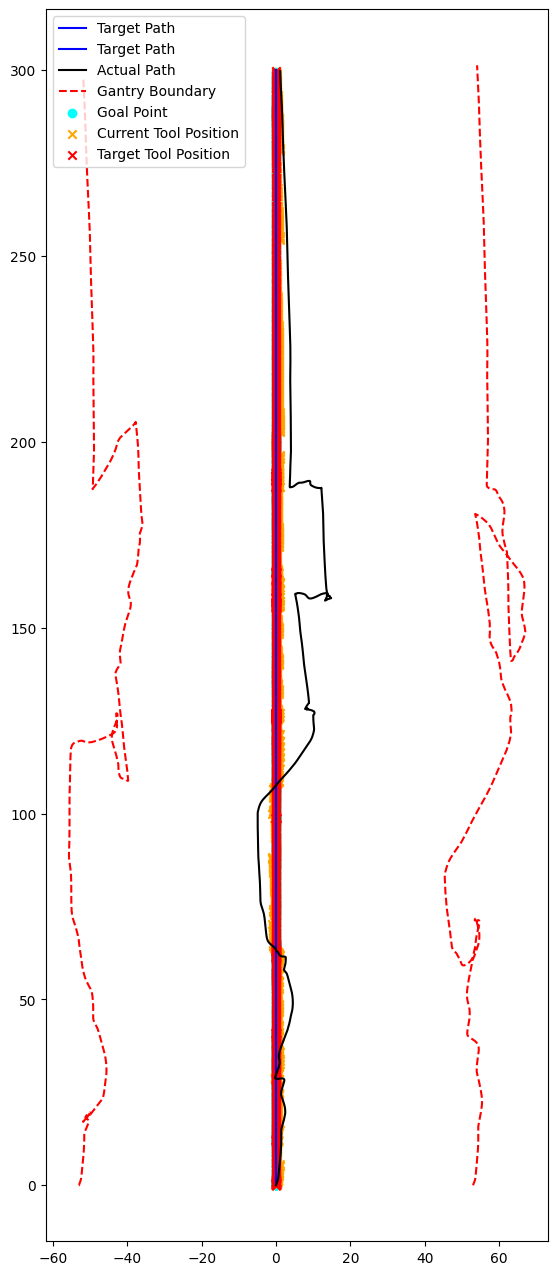

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
matplotlib.rcParams['figure.figsize'] = [16,16]

for i in range(len(target_paths)): 
    target_x = target_paths[i,:,TARGET_PATH_X]
    target_y = target_paths[i,:,TARGET_PATH_Y]
    plt.plot(target_x, target_y, label='Target Path', color='b')

actual_x = actual_path[:,ACTUAL_PATH_X]
actual_y = actual_path[:,ACTUAL_PATH_Y]
plt.plot(actual_x, actual_y, label='Actual Path', color='k')

yaw = actual_path[:,ACTUAL_PATH_YAW]
left_x = actual_x - GANTRY_LENGTH_MM/2 * np.cos(yaw)
left_y = actual_y - GANTRY_LENGTH_MM/2 * np.sin(yaw)
right_x = actual_x + GANTRY_LENGTH_MM/2 * np.cos(yaw)
right_y = actual_y + GANTRY_LENGTH_MM/2 * np.sin(yaw)
plt.plot(left_x, left_y, label='Gantry Boundary', color='r', linestyle='dashed')
plt.plot(right_x, right_y, color='r', linestyle='dashed')

goal_x = actual_path[:,ACTUAL_PATH_GOAL_X]
goal_y = actual_path[:,ACTUAL_PATH_GOAL_Y]
plt.scatter(goal_x, goal_y, label='Goal Point', color='cyan')

tool_x = actual_path[:,ACTUAL_PATH_TOOL_X]
tool_y = actual_path[:,ACTUAL_PATH_TOOL_Y]
plt.scatter(tool_x, tool_y, label='Current Tool Position', color='orange', marker='x')

target_x = actual_path[:,DESIRED_PATH_TOOL_X]
target_y = actual_path[:,DESIRED_PATH_TOOL_Y]
plt.scatter(target_x, target_y, label='Target Tool Position', color='red', marker='x')

ax = plt.gca()
ax.set_aspect('equal')
plt.legend()

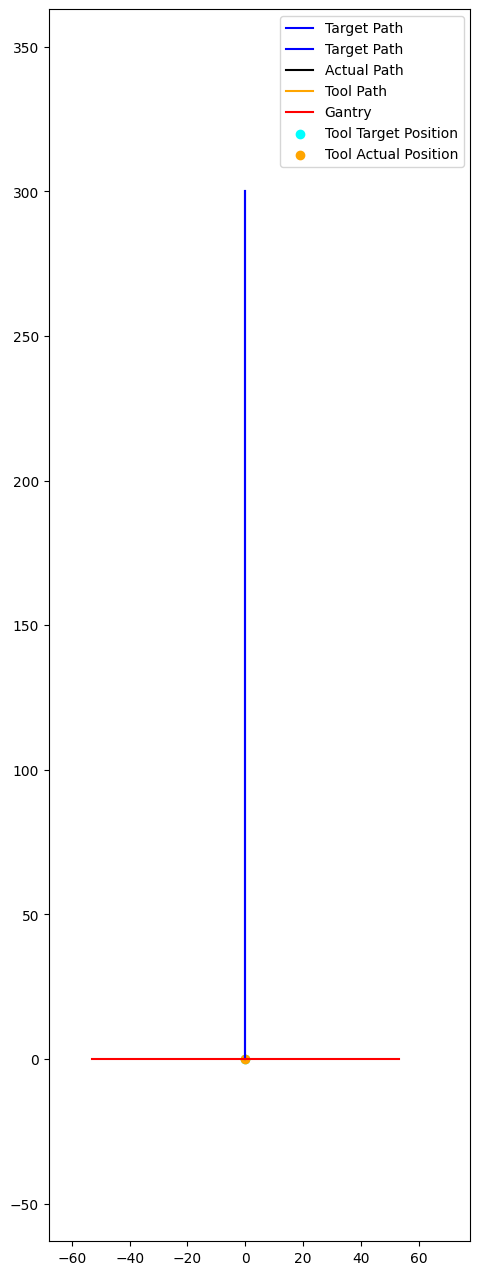

In [6]:
# Get the min/max value of all points to set plot bounds
plt.rcParams["animation.html"] = "jshtml"

all_x = np.concatenate((
    target_paths[:,:,TARGET_PATH_X].flatten(), 
    actual_path[:,ACTUAL_PATH_X],
))

all_y = np.concatenate((
    target_paths[:,:,TARGET_PATH_Y].flatten(),
    actual_path[:,ACTUAL_PATH_Y],
))

min_x = all_x.min() - PLOT_PADDING
max_x = all_x.max() + PLOT_PADDING
min_y = all_y.min() - PLOT_PADDING
max_y = all_y.max() + PLOT_PADDING

actual_path_x = []
actual_path_y = []

f,ax = plt.subplots(1,1)
ax.set_aspect('equal')
ax.set_xlim(min_x,max_x)
ax.set_ylim(min_y,max_y)

for i in range(len(target_paths)): 
    target_x = target_paths[i,:,TARGET_PATH_X]
    target_y = target_paths[i,:,TARGET_PATH_Y]
    ax.plot(target_x, target_y, label='Target Path', color='b')

actual_path_line, = ax.plot([],[],label='Actual Path', color='k')
actual_cut_path_line, = ax.plot([],[],label='Tool Path', color='orange')
gantry_line, = ax.plot([],[],label='Gantry', color='r')
goal_scatter = ax.scatter([],[],color='cyan', label='Tool Target Position')
tool_scatter = ax.scatter([],[],color='orange', label='Tool Actual Position') 

ax.legend()

DOWNSAMPLE = 1

def animate_func(i):
    actual_path_x = actual_path[0:i*DOWNSAMPLE:DOWNSAMPLE,ACTUAL_PATH_X]
    actual_path_y = actual_path[0:i*DOWNSAMPLE:DOWNSAMPLE,ACTUAL_PATH_Y]
    actual_path_line.set_data(actual_path_x, actual_path_y)
    
    cut_path_x = actual_path[0:i*DOWNSAMPLE:DOWNSAMPLE, ACTUAL_PATH_TOOL_X]
    cut_path_y = actual_path[0:i*DOWNSAMPLE:DOWNSAMPLE, ACTUAL_PATH_TOOL_Y]
    actual_cut_path_line.set_data(cut_path_x, cut_path_y)
    
    current_x = actual_path[i*DOWNSAMPLE, ACTUAL_PATH_X]
    current_y = actual_path[i*DOWNSAMPLE, ACTUAL_PATH_Y]
    current_yaw = actual_path[i*DOWNSAMPLE, ACTUAL_PATH_YAW]
    
    gantry_x = [current_x - GANTRY_LENGTH_MM/2*np.cos(current_yaw), current_x + GANTRY_LENGTH_MM/2*np.cos(current_yaw)]
    gantry_y = [current_y - GANTRY_LENGTH_MM/2*np.sin(current_yaw), current_y + GANTRY_LENGTH_MM/2*np.sin(current_yaw)]
    gantry_line.set_data(gantry_x, gantry_y)
    
    #Plot a marker for the current goal point
    goal_scatter.set_offsets(
        actual_path[i*DOWNSAMPLE, [DESIRED_PATH_TOOL_X, DESIRED_PATH_TOOL_Y]]
    )
    
    # Plot a marker for the current tool position, color based on whether or not it's cutting
    tool_scatter.set_offsets(
        actual_path[i*DOWNSAMPLE, [ACTUAL_PATH_TOOL_X, ACTUAL_PATH_TOOL_Y]]
    )
    
    return actual_path_line, actual_cut_path_line, gantry_line, goal_scatter, tool_scatter
    
ani = FuncAnimation(f, animate_func, len(actual_path)//DOWNSAMPLE, interval=50)   
ani.save('animation.mp4', writer='ffmpeg', fps=30)